# Stochastic NN on full sum

In [1]:
import numpy as np
from matplotlib import pylab as plt

In [2]:
import src.operate_datasets    as operate_datasets
import src.model_visualisation as model_visualisation
import src.model_evaluation    as model_evaluation

Welcome to JupyROOT 6.18/00


## Load data

In [3]:
full_X, full_y = operate_datasets.load_dataset('~/snd_data/new_dataset/', 'sum')

X_train, y_train, X_test, y_test = operate_datasets.split_dataset(full_X, full_y)

In [4]:
X_train.shape

(108000,)

In [5]:
X_train = X_train.reshape(-1, 1)
#y_train = y_train.reshape(-1, 1)

X_test = X_test.reshape(-1, 1)
#y_test = y_test.reshape(-1, 1)

In [6]:
min_clip = 0
#X_train, y_train = operate_datasets.clip_dataset(X_train, y_train, min_clip)

## Fit model

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import constraints
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

In [8]:
X_tens = torch.tensor(X_train).float()
y_tens = torch.tensor(y_train).float()

X_test_tens = torch.tensor(X_test).float()
y_test_tens = torch.tensor(y_test).float()

In [9]:
X_test_tens.shape

torch.Size([12000, 1])

In [10]:
class BNN(PyroModule):
    def __init__(self, inp_dim, hid_dim):
        super().__init__()
        
        self.fc1 = PyroModule[nn.Linear](inp_dim, hid_dim)
        self.fc2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.fc3 = PyroModule[nn.Linear](hid_dim, 1)

        # register random values that Pyro will work with
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, inp_dim]).to_event(2))
        self.fc1.bias   = PyroSample(dist.Normal(0., 1.).expand([hid_dim]).to_event(1))

        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, hid_dim]).to_event(2))
        self.fc2.bias   = PyroSample(dist.Normal(0., 1.).expand([hid_dim]).to_event(1))

        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, hid_dim]).to_event(2))
        self.fc3.bias   = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        return       


    def forward(self, x, y):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        mu = self.fc3(x).squeeze()

        # Pyro's sampling
        sigma = pyro.sample("sigma", dist.Uniform(0., 0.1))
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y.squeeze())
        
        return mu

In [11]:
def run_training(num_iter):
    model = BNN(1, 4)    
    guide = AutoDiagonalNormal(model) 

    predictive = Predictive(model, guide=guide, num_samples=2000,
                            return_sites=("obs", "_RETURN"))
    
    initial_lr = 0.001
    gamma = 0.1  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / num_iter)    
    adam = pyro.optim.ClippedAdam({'lr' : initial_lr}) # 'lrd' : lrd , 'betas' : (0.95, 0.999)
    
    svi = SVI(model, guide, adam, loss=Trace_ELBO(num_particles=10))
    
    pyro.clear_param_store()

    loss_arr = []

    for j in range(num_iter):
        running_loss = 0

        loss = svi.step(X_tens, y_tens)
        running_loss += loss

        loss_arr.append(running_loss)
        
        if (j + 1) % 100 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss))

    return model, loss_arr, predictive

In [12]:
# get predictions on the full dataset for analysis

from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std":  torch.std(v, 0),
            "5%":   v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%":  v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [13]:
model, loss_arr, predictive = run_training(3000)

[iteration 0100] loss: 4215715564.5516
[iteration 0200] loss: 3123087962.0940
[iteration 0300] loss: 2868146399.2038
[iteration 0400] loss: 365915366.6766
[iteration 0500] loss: 164614068.3674
[iteration 0600] loss: 10039417.7994
[iteration 0700] loss: 936587.6217
[iteration 0800] loss: 1352646.2032
[iteration 0900] loss: 458866.1874
[iteration 1000] loss: 629796.5656
[iteration 1100] loss: 284764.2021
[iteration 1200] loss: 3011670.2272
[iteration 1300] loss: 199056.9834
[iteration 1400] loss: 613333.4044
[iteration 1500] loss: 160021.1052
[iteration 1600] loss: 247582.8774
[iteration 1700] loss: 533526.5488
[iteration 1800] loss: 574982.6619
[iteration 1900] loss: 250065.7077
[iteration 2000] loss: 71111.9800
[iteration 2100] loss: 63793.8977
[iteration 2200] loss: 68843.8072
[iteration 2300] loss: 57505.7409
[iteration 2400] loss: 89791.0779
[iteration 2500] loss: 364049.2190
[iteration 2600] loss: 127419.9840
[iteration 2700] loss: 165605.6311
[iteration 2800] loss: 23958.7389
[ite

In [14]:
samples = predictive(X_tens, y_tens)
pred_summary = summary(samples)

y_pred     = pred_summary['_RETURN']['mean'].detach().cpu().numpy()
y_pred_min = pred_summary['_RETURN']['5%']  .detach().cpu().numpy()
y_pred_max = pred_summary['_RETURN']['95%'] .detach().cpu().numpy()

In [15]:
y_pred

array([0.27434534, 0.14994363, 0.27671108, ..., 0.27360088, 0.24022245,
       0.2673896 ], dtype=float32)

## Visualise results

In [16]:
X_sum = X_train.sum(axis=1).reshape(-1,1)

In [17]:
y_train = y_train.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [18]:
model_name = 'BNN on full sum'
save_file_prefix = model_name.replace(' ', '-')

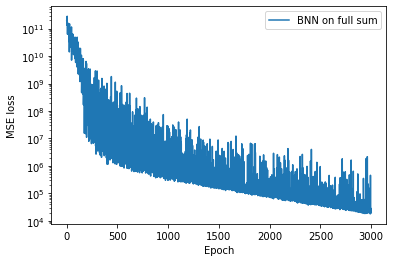

In [19]:
def plot_loss_arrays(loss_dict):
    for key in loss_dict.keys():
        plt.plot(loss_dict[key][0:], label=key)
    
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylabel('MSE loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    return
    
plot_loss_arrays({model_name : loss_arr})

In [20]:
import matplotlib as mpl

def plot_2d_energy_hist_conf_int(X_full, y_true, y_pred, y_pred_min, y_pred_max, clip, model_name):
    fig, ax = plt.subplots(figsize=(8,6))

    plt.xlim(0,None)
    
    hist = ax.hist2d(X_full[:, 0], y_true[:, 0], 
                     bins=100, norm=mpl.colors.LogNorm(), vmax=150)
    
    plt.xlabel('Total number of hits in the detector')
    plt.ylabel(r'Normalised $E_{true}$')

    plt.axvline(x=clip, c='m', alpha=0.9, label='Min clip ' + str(clip))

    ax.plot(X_full, y_pred_min, 'green', marker='.', linestyle='None', alpha=0.3, label='5% percentile')
    ax.plot(X_full, y_pred_max, 'yellow', marker='.', linestyle='None', alpha=0.3, label='95% percentile')

    ax.plot(X_full, y_pred, 'deeppink', marker='.', linestyle='None', alpha=0.3, label=model_name)

    cbar = fig.colorbar(hist[3], ax=ax)
    cbar.set_label('Number of events')

    plt.legend(loc='lower right')
    return fig


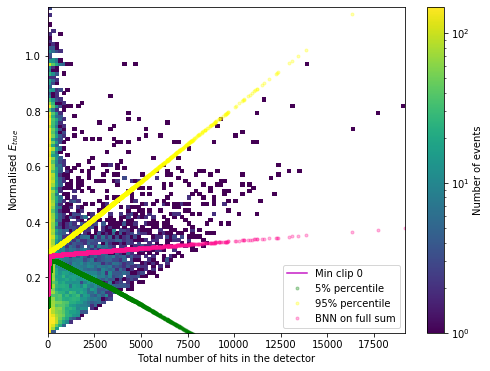

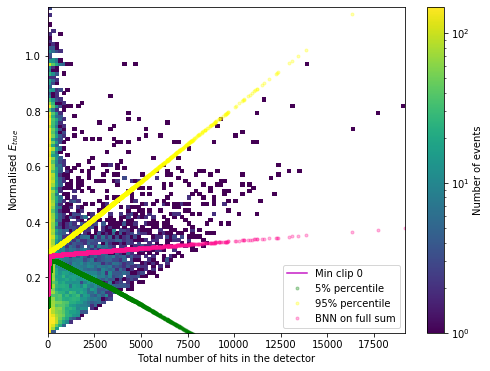

In [21]:
plot_2d_energy_hist_conf_int(X_sum, y_train, y_pred, y_pred_min, y_pred_max, 0, model_name) 

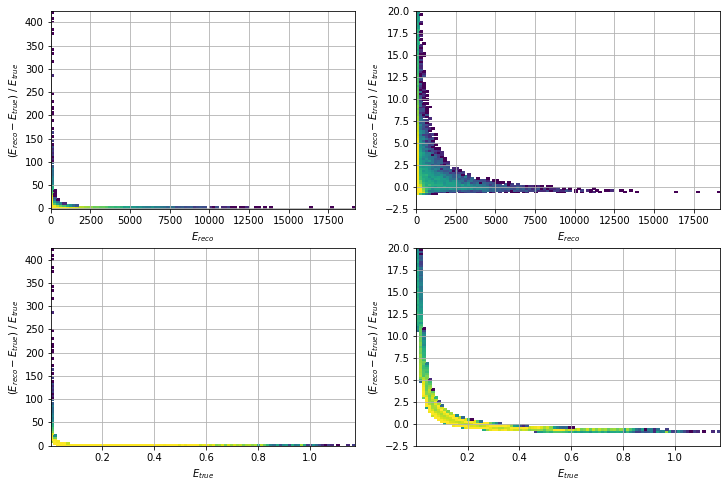

In [22]:
model_visualisation.plot_res_vs_energy(X_sum, y_train, y_pred, vmax=450,
                                       save_file_prefix=save_file_prefix) 

mean   = 1.77955e+00
std    = 6.42308e+00
median = 3.55168e-01


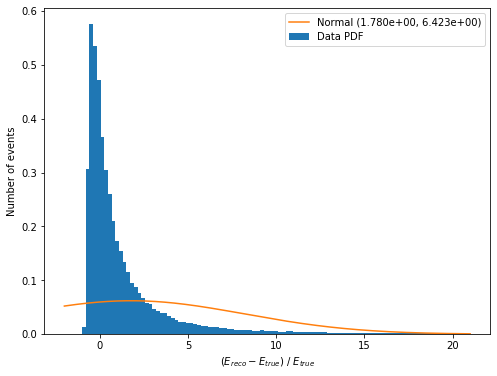

In [23]:
model_visualisation.plot_res_hist_fit(y_train, y_pred, [-1,20],
                                      save_file_prefix=save_file_prefix)

In [24]:
model_evaluation.save_scores(y_train, y_pred, save_file_prefix)

explained_variance_score 0.14639097472216578
max_error 1.026264338192626
mean_absolute_error 0.12534898000412914
mean_squared_error 0.027319963923494065
median_absolute_error 0.10353647494926427
r2_score 0.14605758771608857


,BNN-on-full-sum
explained_variance_score,0.146391
max_error,1.026264
mean_absolute_error,0.125349
mean_squared_error,0.027320
median_absolute_error,0.103536
r2_score,0.146058
avg_resolution,1.779547
std_resolution,6.423076


## Validation

In [25]:
X_sum_test = X_test.sum(axis=1).reshape(-1,1)
y_test = y_test.reshape(-1,1)

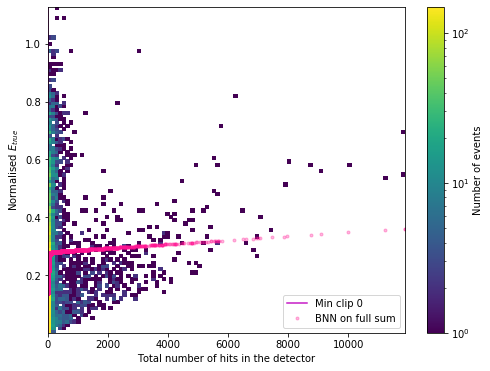

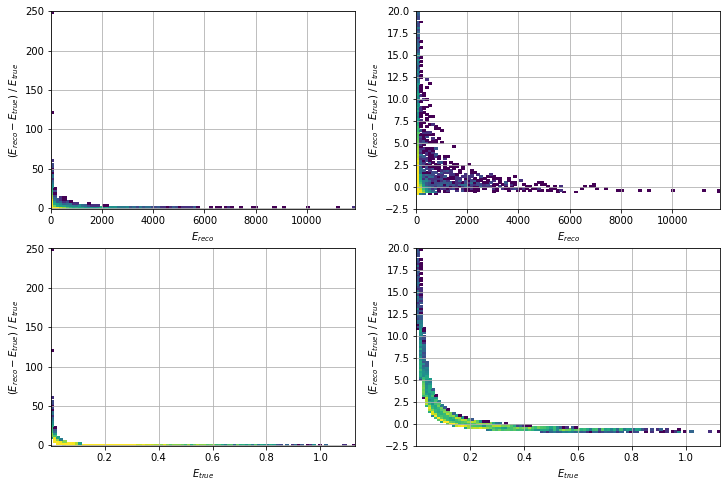

mean   = 1.68965e+00
std    = 4.97317e+00
median = 3.40031e-01


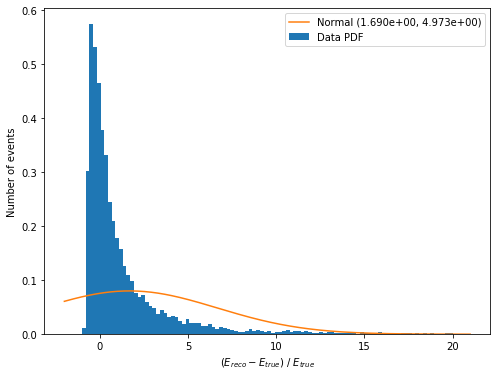

explained_variance_score 0.15754490541135602
max_error 0.8484949258087844
mean_absolute_error 0.12474203194027522
mean_squared_error 0.026880876279840774
median_absolute_error 0.10388637362665493
r2_score 0.15713783784475044


,BNN-on-full-sum
explained_variance_score,0.157545
max_error,0.848495
mean_absolute_error,0.124742
mean_squared_error,0.026881
median_absolute_error,0.103886
r2_score,0.157138
avg_resolution,1.689654
std_resolution,4.973166


In [27]:
samples = predictive(X_test_tens, y_test_tens)
pred_summary = summary(samples)
y_pred_test = pred_summary['_RETURN']['mean'].detach().cpu().numpy()


model_visualisation.plot_2d_energy_hist_clip(X_sum_test, y_test, y_pred_test, min_clip, model_name,
                                             save_file_prefix=save_file_prefix) 

model_visualisation.plot_res_vs_energy(X_sum_test, y_test, y_pred_test, vmax=150,
                                       save_file_prefix=save_file_prefix)  

model_visualisation.plot_res_hist_fit(y_test, y_pred_test, [-1,20],
                                      save_file_prefix=save_file_prefix)

model_evaluation.save_scores(y_test, y_pred_test, save_file_prefix, 
                             folder_path=model_evaluation.TEST_SCORES_DIR)